In [1]:
import os

import torch
import numpy as np
import seaborn as sns

In [2]:
IMAGE_FORMAT = ['jpeg', 'jpg', 'png']

def list_image_files(data_dir, sub_dir):
    image_files = []
    images_dir = os.path.join(data_dir, sub_dir)
    for file_path in os.listdir(images_dir):
        if file_path.split('.')[-1] in IMAGE_FORMAT:
            image_files.append(os.path.join(sub_dir, file_path))
    return image_files

In [3]:
data_dir = '../../datasets/Covid19-dataset/train/'
test_dir = '../../datasets/Covid19-dataset/test/'
normals_list = list_image_files(data_dir, 'Normal')
covids_list = list_image_files(data_dir, 'Covid')
pneumonias_list = list_image_files(data_dir, 'Viral Pneumonia')

print(f'Normal : {len(normals_list)}, Covid : {len(covids_list)}, Pneu : {len(pneumonias_list)}')
t_normals_list = list_image_files(test_dir, 'Normal')
t_covids_list = list_image_files(test_dir, 'Covid')
t_pneumonias_list = list_image_files(test_dir, 'Viral Pneumonia')
print(f'Normal : {len(t_normals_list)}, Covid : {len(t_covids_list)}, Pneu : {len(t_pneumonias_list)}')

Normal : 70, Covid : 111, Pneu : 70
Normal : 20, Covid : 26, Pneu : 20


# 이미지 파일 불러오기

In [4]:
import cv2

In [5]:
def get_RGB_image(data_dir, file_name):
    print(data_dir, file_name)
    image_file = os.path.join(data_dir, file_name)
    # print(image_file)
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
    

# 이미지 확인하기

In [6]:
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

In [7]:
min_num_files = min(len(normals_list), len(covids_list), len(pneumonias_list))
print(min_num_files)

70


In [8]:
# @interact(index=(0, min_num_files-1))
def show_samples(index=0):
    normal_image = get_RGB_image(data_dir, normals_list[index])
    covid_image = get_RGB_image(data_dir, covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, pneumonias_list[index])
    
    plt.figure(figsize=(6,2))
    plt.subplot(131)
    plt.title('Normal')
    plt.imshow(normal_image)
    
    plt.subplot(132)
    plt.title('Covid')
    plt.imshow(covid_image)
    
    plt.subplot(133)
    plt.title('Pneumonia')
    plt.imshow(pneumonia_image)
    plt.show()

../../datasets/Covid19-dataset/train/ Normal\019.jpeg
../../datasets/Covid19-dataset/train/ Covid\025.jpeg
../../datasets/Covid19-dataset/train/ Viral Pneumonia\021.jpeg


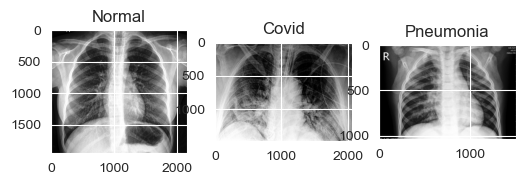

In [9]:
show_samples(10)

# 학습 데이터셋 클래스 구축

In [10]:
train_data_dir = "../../datasets/Covid19-dataset/train"
class_list = ['Normal', 'Covid', 'Viral Pneumonia']

In [11]:
import torch

class ChestDataset:
    def __init__(self, data_dir, transformer=None):
        self.data_dir = data_dir
        normals = list_image_files(data_dir, 'Normal')
        covids = list_image_files(data_dir, 'Covid')
        pneumonias = list_image_files(data_dir, 'Viral Pneumonia')
        
        self.files_path = normals + covids + pneumonias
        if transformer:
            self.transformer = transformer
        else:
            self.transformer = lambda x: torch.Tensor(x)
    def __len__(self):
        return len(self.files_path)
    
    def __getitem__(self, idx):
        image_file = os.path.join(self.data_dir, self.files_path[idx])
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        class_id = class_list.index(self.files_path[idx].split(os.sep)[0])
        
        return self.transformer(image), torch.LongTensor([class_id])

In [12]:
chest_dataset = ChestDataset(data_dir)

In [13]:
image, label = chest_dataset[200]
type(image), image.shape, type(label),label

(torch.Tensor, torch.Size([1024, 1336, 3]), torch.Tensor, tensor([2]))

In [14]:
len(chest_dataset)

251

# 데이터 변환

In [15]:
from torchvision import transforms

In [16]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5,0.5])
])

In [17]:
train_dataset = ChestDataset(data_dir, transformer)

In [18]:
image, label = train_dataset[0]
print(image.shape, label)

torch.Size([3, 224, 224]) tensor([0])


C:\Users\dukim\miniconda3\envs\bootcamp_playground\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# 데이터로더 구현

In [19]:
from torch.utils.data import DataLoader

In [20]:
def build_dataloader(train_path, val_path=None):
    train_dset = ChestDataset(train_path, transformer)
    train_loader = DataLoader(train_dset, batch_size=4, shuffle=True, drop_last=True)
    if val_path:
        test_dset = ChestDataset(val_path, transformer)
        valid_loader = DataLoader(test_dset, batch_size=1, shuffle=False)
        return train_loader, valid_loader
    else:
        return train_loader

In [21]:
train_data_path = '../../datasets/Covid19-dataset/train/'
test_data_path = '../../datasets/Covid19-dataset/test/'

train_loader, valid_loader = build_dataloader(train_data_path, test_data_path)
print(len(train_loader), len(valid_loader))

62 66


In [22]:
from torchvision import models

In [23]:
model = models.vgg19(pretrained=True)

C:\Users\dukim\miniconda3\envs\bootcamp_playground\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dukim\miniconda3\envs\bootcamp_playground\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [25]:
from torchsummary import summary
summary(model, (3,224,244), batch_size=1, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 244]           1,792
              ReLU-2          [1, 64, 224, 244]               0
            Conv2d-3          [1, 64, 224, 244]          36,928
              ReLU-4          [1, 64, 224, 244]               0
         MaxPool2d-5          [1, 64, 112, 122]               0
            Conv2d-6         [1, 128, 112, 122]          73,856
              ReLU-7         [1, 128, 112, 122]               0
            Conv2d-8         [1, 128, 112, 122]         147,584
              ReLU-9         [1, 128, 112, 122]               0
        MaxPool2d-10           [1, 128, 56, 61]               0
           Conv2d-11           [1, 256, 56, 61]         295,168
             ReLU-12           [1, 256, 56, 61]               0
           Conv2d-13           [1, 256, 56, 61]         590,080
             ReLU-14           [1, 256,

# 모델 head 부분 변경하기

In [26]:
import torch.nn as nn

In [27]:
# Ih x Iw -> avgpool(output_size=(Oh,Ow)) -> Oh x Ow
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 3),
    nn.Sigmoid()
)

In [28]:
device = torch.device('cuda')

In [29]:
def build_vgg19_based_model(device='cpu'):
    device = torch.device(device)
    model = models.vgg19(pretrained=True)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 3),
        nn.Softmax(dim=1)
    )
    return model.to(device)

In [30]:
model = build_vgg19_based_model(device)
summary(model, (3,224,244), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 244]           1,792
              ReLU-2          [1, 64, 224, 244]               0
            Conv2d-3          [1, 64, 224, 244]          36,928
              ReLU-4          [1, 64, 224, 244]               0
         MaxPool2d-5          [1, 64, 112, 122]               0
            Conv2d-6         [1, 128, 112, 122]          73,856
              ReLU-7         [1, 128, 112, 122]               0
            Conv2d-8         [1, 128, 112, 122]         147,584
              ReLU-9         [1, 128, 112, 122]               0
        MaxPool2d-10           [1, 128, 56, 61]               0
           Conv2d-11           [1, 256, 56, 61]         295,168
             ReLU-12           [1, 256, 56, 61]               0
           Conv2d-13           [1, 256, 56, 61]         590,080
             ReLU-14           [1, 256,

# Loss 정의

In [31]:
loss_func = nn.CrossEntropyLoss(reduction='mean')

# optimizer

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 모델 학습 함수

In [33]:
@torch.no_grad()
def get_accuracy(image, target, model):
    batch_size = image.shape[0]
    preds = model(image)
    _, pred_label = torch.max(preds, dim=1)
    is_correct = (pred_label == target)
    accuracy = is_correct.cpu().numpy().sum() / batch_size
    return accuracy

In [34]:
def train_one_epoch(train_dataloader, valid_dataloader, model, optimizer, loss_f, device, verbose=None):
    train_loss_list = []
    train_acc_list = []
    model.train()
    for idx, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = torch.squeeze(labels).to(device)
        # predition
        preds = model(images)
        loss = loss_f(preds, labels)
        # weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_list.append(loss.item())
        train_acc_list.append(get_accuracy(images, labels, model))
    if verbose:
        print(f'train loss : {sum(train_loss_list)/len(train_dataloader)}')
    
    val_loss_list = []
    val_acc_list = []
    model.eval()
    with torch.no_grad():
        for idx, (images, labels) in enumerate(valid_dataloader):
            images = images.to(device)
            labels = labels.view(-1).to(device)
            # prediction 
            preds = model(images)
            loss = loss_f(preds, labels)
            val_loss_list.append(loss.item())
            val_acc_list.append(get_accuracy(images, labels, model))
    if verbose:
        print(f'valid loss : {sum(val_loss_list)/len(valid_dataloader)}')
    return np.sum(train_loss_list)/len(train_dataloader), np.mean(train_acc_list), np.sum(val_loss_list)/len(valid_dataloader), np.mean(val_acc_list)

In [35]:
train_loss, train_acc, val_loss, val_acc = train_one_epoch(train_loader, valid_loader, model, optimizer, loss_func, device)
print(f'train loss : {train_loss}, acc : {train_acc}')
print(f'validation loss : {val_loss}, acc : {val_acc}')

train loss : 1.2738874804589055, acc : 0.2782258064516129
validation loss : 1.2484144658753367, acc : 0.30303030303030304


# Accuracy 생성

# 모델 수행평가

In [36]:
num_epochs = 10
best_acc = 0.0
train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []

model = build_vgg19_based_model(device)
loss_func = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

for epoch in range(num_epochs):
    train_loss, train_acc, val_loss, val_acc = train_one_epoch(train_loader, valid_loader, model, optimizer, loss_func, device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print(f'epoch [{epoch+1}/{num_epochs}] train [loss: {train_loss:.4f}, acc: {train_acc:.4f}], valid [loss: {val_loss:.4f}, acc: {val_acc:.4f}]')

epoch [1/10] train [loss: 1.0586, acc: 0.4879], valid [loss: 0.9420, acc: 0.7424]
epoch [2/10] train [loss: 0.9159, acc: 0.6532], valid [loss: 1.1415, acc: 0.3030]
epoch [3/10] train [loss: 0.9903, acc: 0.6331], valid [loss: 0.8656, acc: 0.6970]
epoch [4/10] train [loss: 0.7754, acc: 0.8266], valid [loss: 0.8492, acc: 0.7121]
epoch [5/10] train [loss: 0.6707, acc: 0.9032], valid [loss: 0.7502, acc: 0.7879]
epoch [6/10] train [loss: 0.6581, acc: 0.9073], valid [loss: 0.8814, acc: 0.6818]
epoch [7/10] train [loss: 0.6991, acc: 0.8871], valid [loss: 0.7400, acc: 0.7879]
epoch [8/10] train [loss: 0.6607, acc: 0.9234], valid [loss: 0.8243, acc: 0.7121]
epoch [9/10] train [loss: 0.5999, acc: 0.9677], valid [loss: 0.6837, acc: 0.8788]
epoch [10/10] train [loss: 0.6424, acc: 0.9395], valid [loss: 0.6256, acc: 0.9242]


<Axes: >

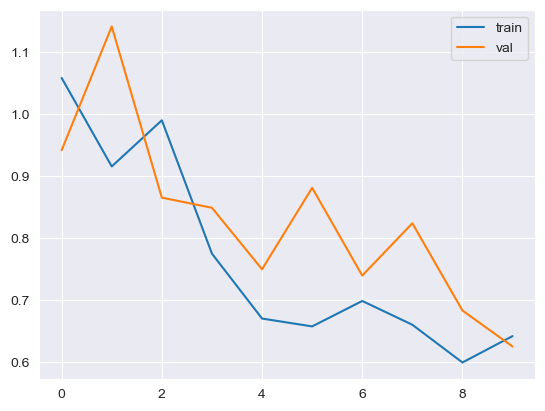

In [37]:
sns.lineplot(train_loss_list, label='train')
sns.lineplot(val_loss_list, label='val')

# 테스트 이미지를 통한 학습 모델 분류 성능 검증하기

In [38]:
def preprocess_image(image):
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224,224)),
        transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ])
    tensor_image = transformer(image) # (C, H, W)
    tensor_image = tensor_image.unsqueeze(dim=0) # (B, C, H, W) = (1, C, H, W)
    return tensor_image

In [49]:
@torch.no_grad()
def model_predict(image, model, device):
    tensor_image = preprocess_image(image).to(device)
    prediction = model(tensor_image)
    _, pred_label = torch.max(prediction.detach().cpu(), dim=1)
    pred_label = pred_label.squeeze(dim=0)
    return pred_label.item()

In [50]:
min_num_files = min(len(t_normals_list), len(t_covids_list), len(t_pneumonias_list))

def show_result(index=0):
    normal_image = get_RGB_image(test_dir, t_normals_list[index])
    covid_image = get_RGB_image(test_dir, t_covids_list[index])
    pneumonia_image = get_RGB_image(test_dir, t_pneumonias_list[index])
    
    pred_normal = model_predict(normal_image, model, device)
    pred_covid = model_predict(covid_image, model, device)
    pred_pneumonia = model_predict(pneumonia_image, model, device)
    
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.title(f'Pred:{class_list[pred_normal]} | GT:Normal')
    plt.imshow(normal_image)
    
    plt.subplot(132)
    plt.title(f'Pred:{class_list[pred_covid]} | GT:Covid')
    plt.imshow(covid_image)
    
    plt.subplot(133)
    plt.title(f'Pred:{class_list[pred_pneumonia]} | GT:Pneumonia')
    plt.imshow(pneumonia_image)

../../datasets/Covid19-dataset/test/ Normal\0115.jpeg
../../datasets/Covid19-dataset/test/ Covid\094.png
../../datasets/Covid19-dataset/test/ Viral Pneumonia\0113.jpeg


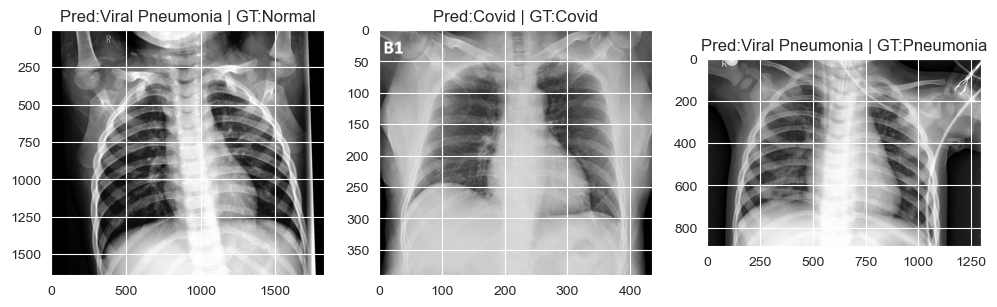

In [60]:
show_result(12)

In [55]:
min_num_files

20